# Assignment 02 - Team Magma
### Collaborators: Alvaro Montoya Ruiz, Hriday Reddy Purma, Mauricio Bermudez

## A. Library Imports


In [52]:
import torch
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn, optim
import torch.nn.init as init

print("Hello World!")

Hello World!


## B. Setting device and processing/cleaning the data

The dataset used for this assignment was retrieved from https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

This is a fictional dataset created by IBM researchers with the aim to predict employee attrition and design models and procedures to minimize financial losses and its impact. In this scenario, reducing false negatives is particularly important since failing to identify employees who may leave could have serious business and economic consequences.

Most of the data in the dataset is numeric; however, there are several categorical variables that need to be considered when analyzing the data:

Nominal Variables: Department, Education Field, Gender, Job Role, Marital Status, and OverTime.
Ordinal Variables: Business Travel, Education Level, Job Involvement, and Job Level. Some of these ordinal variables were mapped by IBM researchers.
By addressing these categorical variables appropriately, the analysis will be able to account for the different categories within each variable and improve the accuracy of predictions regarding employee attrition.

In [53]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
url = 'https://raw.githubusercontent.com/m-bermudez/ISM6561-Deep-Learning/refs/heads/main/EmployeeAttrition.csv'
df = pd.read_csv(url)

# Data cleaning and preprocessing
df = df.dropna()  # Drop missing values

## C. Encoding the data

The categorical data was encoding using one hot dummies for the nominal columns and a mapping for ordinal columns such as well binary data

In [54]:
# Ordinal Mapping for 'BusinessTravel' column
business_travel_mapping = {
    'Non-Travel': 0,
    'Travel_Rarely': 1,
    'Travel_Frequently': 2
}
df['BusinessTravel'] = df['BusinessTravel'].map(business_travel_mapping)

# One-Hot Encoding for Nominal Columns
nominal_columns = [
    'Department',
    'EducationField',
    'Gender',
    'JobRole',
    'MaritalStatus'
]
df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)

# Binary Encoding for 'Over18', 'Overtime', and 'Attrition'
df['Over18'] = df['Over18'].map({'Y': 1, 'N': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Drop 'EmployeeCount' and 'EmployeeNumber' columns
df = df.drop(columns=['EmployeeCount', 'EmployeeNumber'])

# Ensure all columns are numeric and of type float32
df = df.apply(pd.to_numeric, errors='coerce').astype('float32')

## D. Defining features and normalizing data

In [55]:
# Define features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## E. Tensor Conversion

In [56]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoaders
batch_size = 64
#batch_size = 128
#batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## F. Defining Neural Network

#### Neural Network Architecture
We implemented a neural network architecture with the following configuration:

#### Number of Layers: T
he network consists of 5 layers:

* 1 input layer
* 3 hidden layers
* 1 output layer

#### Number of Neurons per Layer:

* Input layer: 32 neurons, corresponding to the feature dimensions of the dataset.
* First hidden layer: 64 neurons
* Second hidden layer: 128 neurons
* Third hidden layer: 64 neurons
* Output layer: 1 neuron, implemented with a sigmoid activation function for binary classification.

#### Activation Functions:

We employed the ELU (Exponential Linear Unit) activation function for all layers. This choice was made to mitigate the vanishing gradient problem and improve the network's ability to learn complex patterns.
Output Layer Activation: A single neuron with a sigmoid activation function is used to produce binary outcomes (0 or 1).

#### Additional Information:
To enhance the model's performance and generalization, we incorporated two key techniques:

* Dropout was applied after each hidden layer to prevent overfitting.
By randomly deactivating a specified percentage of neurons during training, dropout ensures that no single neuron becomes too influential, encouraging the network to learn redundant feature representations. This improves robustness and generalization.

* Batch normalization was implemented for each layer to stabilize and accelerate the training process.
By normalizing the inputs across mini-batches, this technique helps reduce internal covariate shift and ensures consistent training dynamics.


One of the challenges faced by our model was its ability to learn at an appropriate rate during training. This issue was addressed through the use of dropout and batch normalization.

In [57]:
# Define the neural network
class MLP(nn.Module):
    def __init__(self, input_size=None):
        super(MLP, self).__init__()
        if input_size is None:
            input_size = X_train.shape[1]
        #Linear Layer 1
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)

        #Linear Layer 2
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)

        #Linear Layer 3
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        #Linear Layer 4 into Sigmoid function
        self.fc4 = nn.Linear(64, 1)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.elu(x)  # ELU after batch normalization
        x = self.dropout(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.elu(x)  
        x = self.dropout(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.elu(x)  
        x = self.dropout(x)
        
        # Output layer
        x = self.fc4(x)
        x = self.sigmoid(x)  # Sigmoid for binary classification
        return x

## G. Defining non trivial loss function and mathematical formulas

### G.1 - Custom BCE Loss Function

Mathematical formula:
y = true label
y^ = predicted probability

BCELoss(y, y^)=− 1/n  n ∑ i=1 (yi * log(yi^)+(1−yi)* log(1− yi^))

In [58]:
# Custom BCE loss function
def custom_bce_loss(outputs, targets):
    outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
    bce_loss = - (targets * torch.log(outputs) + (1 - targets) * torch.log(1 - outputs))
    return bce_loss.mean()


### G.2 - Custom Hinge Loss Function

Mathematical formula:
y = true label
y^ = predicted probability

Hingeloss(y, y^)= 1/n  n ∑ i=1  max(0,1−yi * yi^)

In [59]:
# Custom Hinge loss function
def custom_hinge_loss(outputs, targets):
   
    # Ensure targets are in {-1, 1} for hinge loss
    targets = 2 * targets - 1  # Convert {0, 1} to {-1, 1}
    
    # Compute hinge loss
    hinge_loss = torch.mean(torch.clamp(1 - targets * outputs, min=0))
    return hinge_loss

### G.3 - Custom KL Divergence Loss Function

Mathematical formula
(Q(x) is the predicted probability)
(P(x) is the true label)

KL(P∣∣Q)=∑x P(x)⋅log(Q(x)/P(x))

In [60]:
def custom_kl_divergence(outputs, targets):
    
    epsilon = 1e-7
    outputs = torch.clamp(outputs, epsilon, 1.0 - epsilon)
    targets = torch.clamp(targets, epsilon, 1.0 - epsilon)
    
    # Compute the KL divergence for each element and reduce by taking mean
    kl_div = targets * torch.log(targets / outputs) + (1 - targets) * torch.log((1 - targets)/(1 - outputs))
    return kl_div.mean()

### G.4 -Explanation of advantages for cost functions

#### BCE Loss:

* Benefits:
BCE measures the difference between predicted probabilities and true labels. It Provides probability estimates, which are useful for decision-making processes requiring confidence score and it has a good performance with sigmoid activation.

* Drawbacks:
BCE is Sensitive to class imbalance. It may perform poorly on minority classes without adjustments like weighting or resampling techniques and it can be computationally more intensive due to logarithmic operations.

#### Hinge loss:

* Benefits:
Hinge Loss focuses on maximizing the margin between classes, potentially leading to faster convergence and robustness against label noise.It is more computationally efficient than other cost functions as it avoids logarithmic operations.

* Drawbacks:
Hinge loss does not provide probability estimates.It focuses solely on correct classification without assessing confidence levels.As a result, it may be less interpretable compared to BCE Loss when determine business decisions to the stakeholders or business owners.

#### KL Divergence:

* Benefits:
KL Divergence can provide more flexibility in certain scenarios due to its nature of comparing distributions. It allows adjustments, especially when the model needs to adapt differently based on data distribution characteristics.

* Drawbacks:
It may require careful implementation to avoid numerical issues, particularly with zero probabilities which can cause instability in computations. That is why we use the epsilon value on the function aboved.KL may be computationally heavier compared to Hinge loss due to additional divergence calculations.

## H. Weight Initialization

### H.1 - Custom initialization function

In [61]:
def initialize_weights(model, method=None, gain=1.0, constant_value=0.1, mean=0.0, std=0.01):
    if method is None:
        print("No initialization required")
        return  

    for name, param in model.named_parameters():
        if 'weight' in name:
            if method == 'orthogonal':
                init.orthogonal_(param, gain=gain)
            elif method == 'constant':
                init.constant_(param, constant_value)
            elif method == 'normal':
                init.normal_(param, mean=mean, std=std)
            else:
                raise ValueError(f"Unsupported initialization method: {method}")
        elif 'bias' in name:
            init.constant_(param, 0.0)  # Initialize biases to 0

### H.2 - Mathematical formulas and parameter explanations

### Constant Initialization

#### Mathematical Formula:
W new=c

where c is a constant value specified by the user (defaulting to 0.0).
W new is the new weight

#### Parameters:
* constant_value: The scalar value to which all weights are initialized. Default is 0.0.

#### Description:
This method initializes all weight parameters to a fixed constant value, typically zero or another small value. This simplicity can be advantageous in certain scenarios but may limit the model's ability to learn diverse features if not carefully considered.

### Normal Initialization

#### Mathematical Formula:
W new∼ N(μ,σ^2)

where μ is the mean (defaulting to 0.0) and σ is the standard deviation (defaulting to 0.01).

#### Parameters:

* mean: The mean of the normal distribution from which weights are drawn.
* std: The standard deviation of the normal distribution.

#### Description:
This method initializes weights using a normal distribution, allowing for variability and preventing all neurons from learning similar features too early. This can enhance the model's capacity to capture diverse patterns in the data.

### Orthogonal Initialization

#### Mathematical Formula:
For an m×n matrix W, ensuring that:
dot(W[:,i],W[:,j])=0 ∀i≠j

#### Parameters:

* gain: A scalar value (defaulting to 1.0) used to scale the initialized weights.

#### Description:
Orthogonal initialization ensures that the columns of the weight matrix are orthogonal to each other and ideally normalized as unit vectors. This helps in maintaining a stable gradient flow during training, which is particularly beneficial for deeper networks by preventing vanishing or exploding gradients.

#### Since the sigmoid function is before the output layer, He initialization would not be a good implementation on this Binary Classifier NN


### H.3 - Rationale and Discussion on performance impact

### Constant Initialization:

Setting all weights to zero can lead to symmetry issues in the Binary classifier. During training, neurons in each layer will update identically because they receive the same input (zeros). This can result in slower convergence and poor performance as the network fails to learn diverse features.

### Normal Initialization:

By initializing weights from a normal distribution with mean 0 and a standard deviation, this method introduces variability, breaking symmetry and allowing each neuron to learn different features.

### Orthogonal Initialization:

This method ensures that weight vectors are orthogonal, preventing vanishing or exploding gradients in deeper networks. This will help maintain stable gradient flow during backpropagation as well with the implementation of ELU for vanishing gradient reduction.

#### Gain Parameter in Orthogonal Initialization:

The gain parameter scales the initialized weights. A higher gain can lead to faster learning but may cause instability, while a lower gain ensures more stable training at the cost of potentially slower convergence. This flexibility allows fine-tuning based on specific needs.


## I. Defining Training Function

In [62]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    accuracy_metric = torchmetrics.Accuracy(task='binary').to(device)

    # Initialize variables for early stopping
    best_val_loss = float('inf')  # Track the best validation loss
    epochs_without_improvement = 0  # Count epochs without improvement
    best_model_weights = None  # Save the best model weights

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0

        # Training phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Compute accuracy
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            accuracy = accuracy_metric(preds, targets)

            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy.item() * inputs.size(0)

        # Compute average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = running_accuracy / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)

                # Compute accuracy
                preds = (outputs > 0.5).float()
                accuracy = accuracy_metric(preds, targets)

                val_loss += loss.item() * inputs.size(0)
                val_accuracy += accuracy.item() * inputs.size(0)

        # Compute average validation loss and accuracy for the epoch
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_accuracy / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update the best validation loss
            epochs_without_improvement = 0  # Reset the counter
            best_model_weights = model.state_dict()  # Save the best model weights
        else:
            epochs_without_improvement += 1  # Increment the counter

        # Stop training if validation loss hasn't improved for `patience` epochs
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1} (no improvement for {patience} epochs).')
            break

    # Load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print('Loaded the best model weights.')

    return train_losses, val_losses, train_accuracies, val_accuracies

## J. Model Evaluation

In [63]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_accuracy = 0.0
    accuracy_metric = torchmetrics.Accuracy(task='binary').to(device)

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            
            # Compute loss
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            # Compute accuracy
            preds = (outputs > 0.5).float()  # For BCE loss, threshold at 0.5
            accuracy = accuracy_metric(preds, targets)
            test_accuracy += accuracy.item() * inputs.size(0)


    y_test = targets.cpu().numpy().astype(int)
    y_pred= preds.cpu().numpy().astype(int)
    
    cm_lr = confusion_matrix(y_test, y_pred)

    disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
    disp_lr.plot()
    plt.title("Confusion Matrix")
    plt.show()
    
    
    accuracy_lr_f1 = accuracy_score(y_test, y_pred)
    precision_lr_f1 = precision_score(y_test, y_pred)
    recall_lr_f1 = recall_score(y_test, y_pred)
    f1_lr_f1 = f1_score(y_test, y_pred)
    
    
    print(f"Logistic Regression Metrics:")
    print(f"Accuracy: {accuracy_lr_f1:.4f}")
    print(f"Precision: {precision_lr_f1:.4f}")
    print(f"Recall: {recall_lr_f1:.4f}")
    print(f"F1 Score: {f1_lr_f1:.4f}")
    # Compute average loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_accuracy / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy

## K. BCE Loss Model

### K.1 - Model Initialization, Loss Function and Optimizer utilizing BCE Loss Function

Epoch [1/50], Train Loss: 0.6872, Train Accuracy: 0.8173, Val Loss: 0.6784, Val Accuracy: 0.8545
Epoch [2/50], Train Loss: 0.6603, Train Accuracy: 0.8484, Val Loss: 0.6481, Val Accuracy: 0.8545
Epoch [3/50], Train Loss: 0.6099, Train Accuracy: 0.8737, Val Loss: 0.6003, Val Accuracy: 0.8545
Epoch [4/50], Train Loss: 0.5445, Train Accuracy: 0.8669, Val Loss: 0.5346, Val Accuracy: 0.8545
Epoch [5/50], Train Loss: 0.4815, Train Accuracy: 0.8571, Val Loss: 0.4462, Val Accuracy: 0.8864
Epoch [6/50], Train Loss: 0.4255, Train Accuracy: 0.8688, Val Loss: 0.4097, Val Accuracy: 0.8955
Epoch [7/50], Train Loss: 0.3841, Train Accuracy: 0.8727, Val Loss: 0.3795, Val Accuracy: 0.9045
Epoch [8/50], Train Loss: 0.3647, Train Accuracy: 0.8766, Val Loss: 0.3474, Val Accuracy: 0.8818
Epoch [9/50], Train Loss: 0.3518, Train Accuracy: 0.8601, Val Loss: 0.3406, Val Accuracy: 0.8955
Epoch [10/50], Train Loss: 0.3299, Train Accuracy: 0.8669, Val Loss: 0.3353, Val Accuracy: 0.8773
Epoch [11/50], Train Loss: 0.

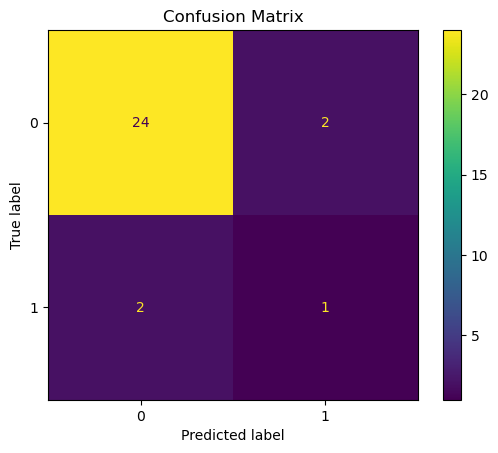

Logistic Regression Metrics:
Accuracy: 0.8621
Precision: 0.3333
Recall: 0.3333
F1 Score: 0.3333
Test Loss: 0.3083, Test Accuracy: 0.8597


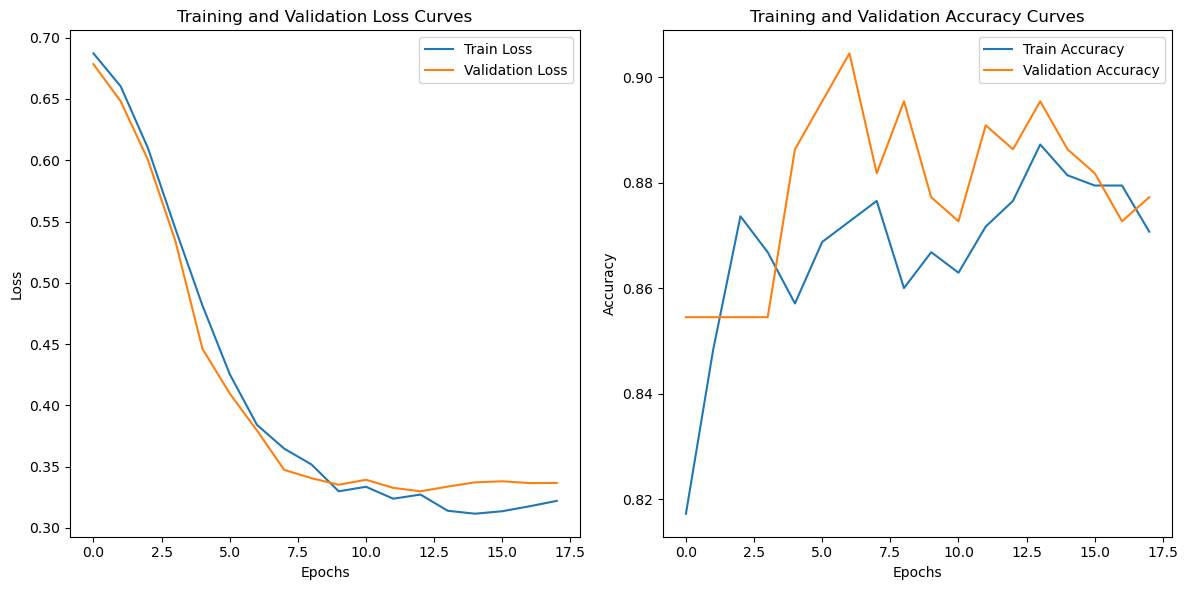

In [64]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='normal', mean=0.0, std=0.01)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_bce_loss  # Or custom_hinge_loss, depending on your choice
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

Epoch [1/50], Train Loss: 0.7434, Train Accuracy: 0.5112, Val Loss: 0.6813, Val Accuracy: 0.6091
Epoch [2/50], Train Loss: 0.6877, Train Accuracy: 0.5753, Val Loss: 0.6499, Val Accuracy: 0.6955
Epoch [3/50], Train Loss: 0.6505, Train Accuracy: 0.6628, Val Loss: 0.6201, Val Accuracy: 0.7318
Epoch [4/50], Train Loss: 0.6182, Train Accuracy: 0.7308, Val Loss: 0.5902, Val Accuracy: 0.7955
Epoch [5/50], Train Loss: 0.5819, Train Accuracy: 0.7804, Val Loss: 0.5577, Val Accuracy: 0.8273
Epoch [6/50], Train Loss: 0.5430, Train Accuracy: 0.8105, Val Loss: 0.5127, Val Accuracy: 0.8500
Epoch [7/50], Train Loss: 0.5032, Train Accuracy: 0.8270, Val Loss: 0.4701, Val Accuracy: 0.8545
Epoch [8/50], Train Loss: 0.4679, Train Accuracy: 0.8290, Val Loss: 0.4421, Val Accuracy: 0.8545
Epoch [9/50], Train Loss: 0.4439, Train Accuracy: 0.8299, Val Loss: 0.4215, Val Accuracy: 0.8545
Epoch [10/50], Train Loss: 0.4209, Train Accuracy: 0.8338, Val Loss: 0.4089, Val Accuracy: 0.8500
Epoch [11/50], Train Loss: 0.

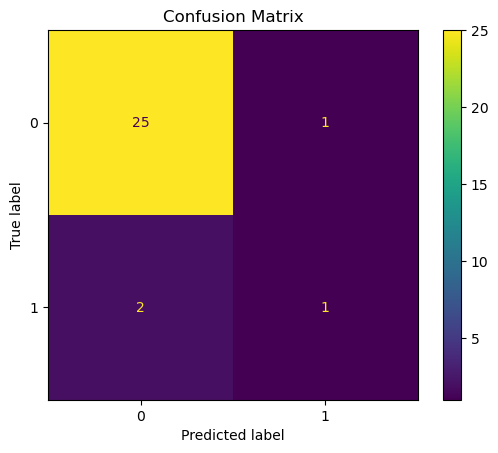

Logistic Regression Metrics:
Accuracy: 0.8966
Precision: 0.5000
Recall: 0.3333
F1 Score: 0.4000
Test Loss: 0.2960, Test Accuracy: 0.8869


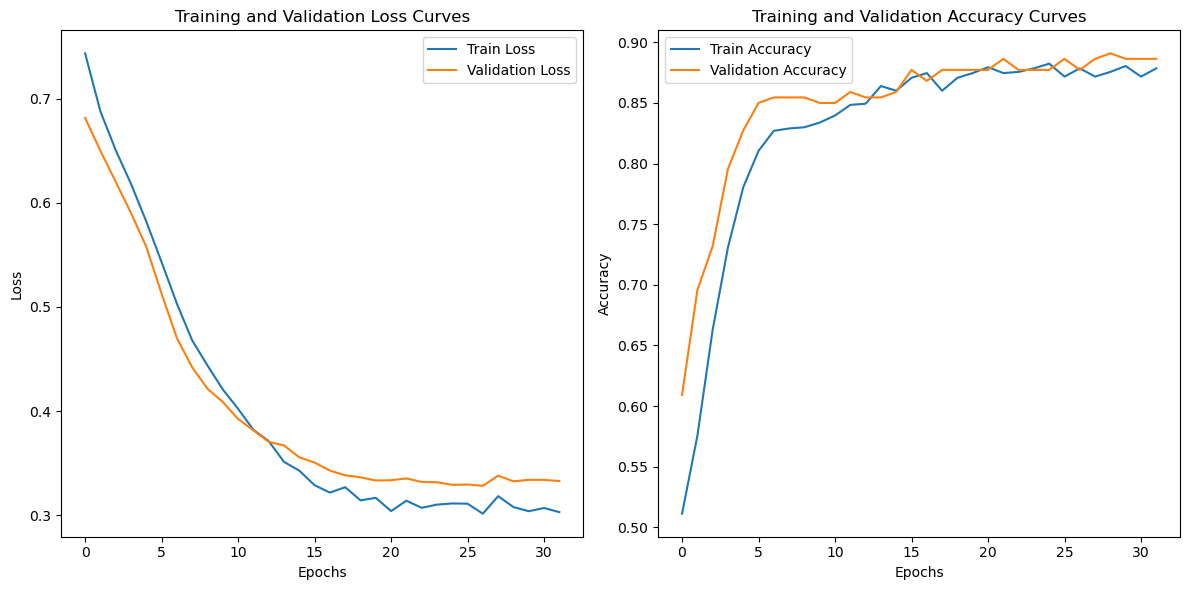

In [65]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='constant', constant_value = 0.1)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

No initialization required
Epoch [1/50], Train Loss: 0.7649, Train Accuracy: 0.4500, Val Loss: 0.6735, Val Accuracy: 0.5818
Epoch [2/50], Train Loss: 0.6824, Train Accuracy: 0.5695, Val Loss: 0.6237, Val Accuracy: 0.6409
Epoch [3/50], Train Loss: 0.6291, Train Accuracy: 0.6560, Val Loss: 0.5753, Val Accuracy: 0.7318
Epoch [4/50], Train Loss: 0.5624, Train Accuracy: 0.7153, Val Loss: 0.5717, Val Accuracy: 0.7227
Epoch [5/50], Train Loss: 0.5480, Train Accuracy: 0.7347, Val Loss: 0.5184, Val Accuracy: 0.7909
Epoch [6/50], Train Loss: 0.5005, Train Accuracy: 0.7775, Val Loss: 0.4978, Val Accuracy: 0.8136
Epoch [7/50], Train Loss: 0.4812, Train Accuracy: 0.7979, Val Loss: 0.4415, Val Accuracy: 0.8682
Epoch [8/50], Train Loss: 0.4700, Train Accuracy: 0.7891, Val Loss: 0.4335, Val Accuracy: 0.8500
Epoch [9/50], Train Loss: 0.4308, Train Accuracy: 0.8134, Val Loss: 0.4125, Val Accuracy: 0.8636
Epoch [10/50], Train Loss: 0.4335, Train Accuracy: 0.8095, Val Loss: 0.3871, Val Accuracy: 0.8682
Ep

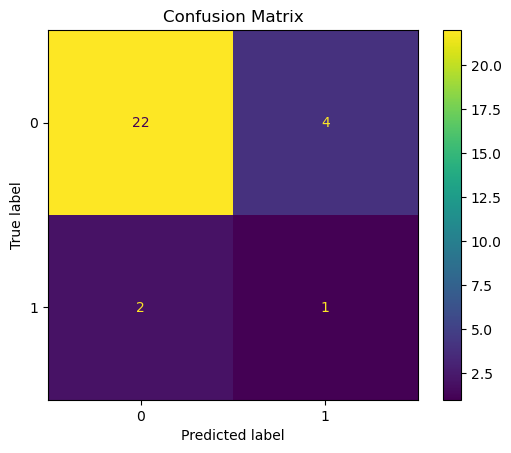

Logistic Regression Metrics:
Accuracy: 0.7931
Precision: 0.2000
Recall: 0.3333
F1 Score: 0.2500
Test Loss: 0.3128, Test Accuracy: 0.8416


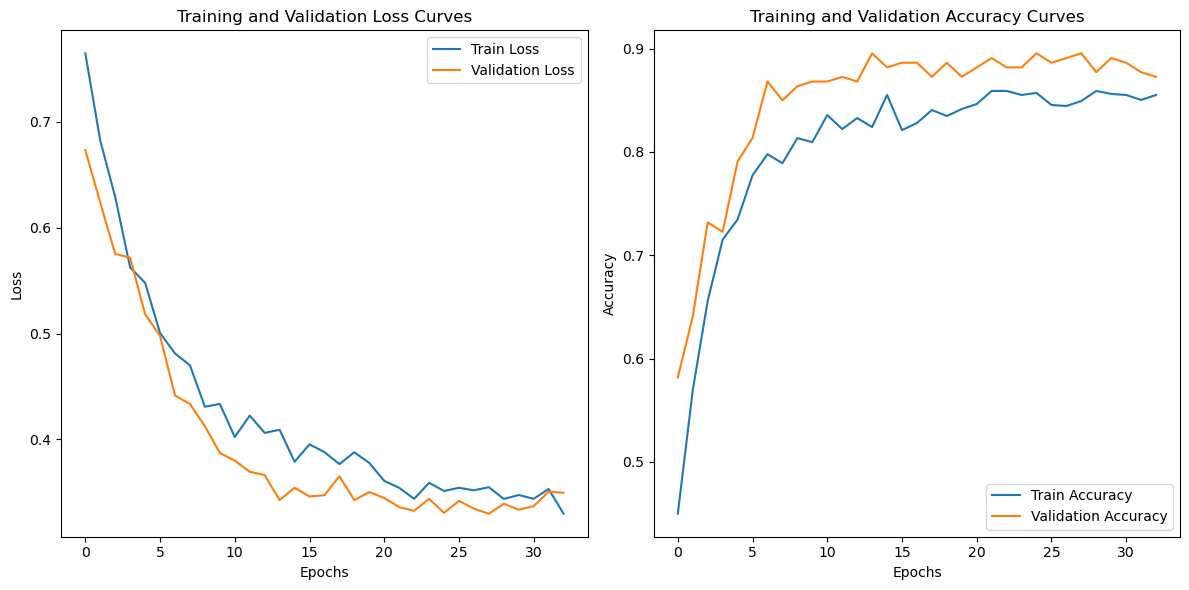

In [66]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='none', constant_value = 0.1)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

### K.2 - Plotting Model for BCE Loss

## L. Hinge Loss Model

### L.1 - Model Initialization, Loss Function and Optimizer utilizing Hinge Loss Function

Epoch [1/50], Train Loss: 1.3263, Train Accuracy: 0.8076, Val Loss: 1.3473, Val Accuracy: 0.8545
Epoch [2/50], Train Loss: 1.3134, Train Accuracy: 0.8465, Val Loss: 1.3319, Val Accuracy: 0.8545
Epoch [3/50], Train Loss: 1.2863, Train Accuracy: 0.8669, Val Loss: 1.3040, Val Accuracy: 0.8545
Epoch [4/50], Train Loss: 1.2437, Train Accuracy: 0.8601, Val Loss: 1.2569, Val Accuracy: 0.8545
Epoch [5/50], Train Loss: 1.1898, Train Accuracy: 0.8610, Val Loss: 1.1876, Val Accuracy: 0.8818
Epoch [6/50], Train Loss: 1.1410, Train Accuracy: 0.8601, Val Loss: 1.1298, Val Accuracy: 0.9000
Epoch [7/50], Train Loss: 1.0978, Train Accuracy: 0.8737, Val Loss: 1.1135, Val Accuracy: 0.8955
Epoch [8/50], Train Loss: 1.0702, Train Accuracy: 0.8571, Val Loss: 1.0694, Val Accuracy: 0.9045
Epoch [9/50], Train Loss: 1.0419, Train Accuracy: 0.8717, Val Loss: 1.0492, Val Accuracy: 0.8864
Epoch [10/50], Train Loss: 1.0268, Train Accuracy: 0.8698, Val Loss: 1.0372, Val Accuracy: 0.8955
Epoch [11/50], Train Loss: 1.

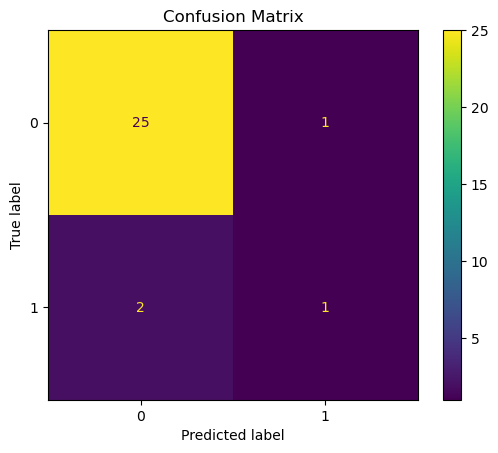

Logistic Regression Metrics:
Accuracy: 0.8966
Precision: 0.5000
Recall: 0.3333
F1 Score: 0.4000
Test Loss: 0.9985, Test Accuracy: 0.8824


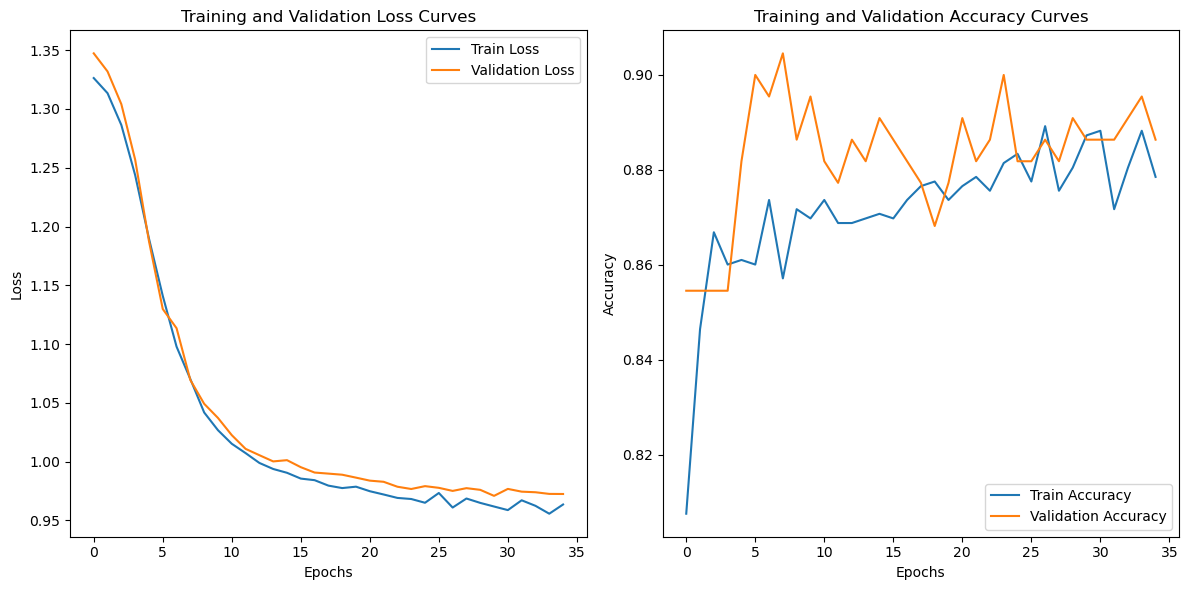

In [67]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='normal', mean=0.0, std=0.01)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_hinge_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

Epoch [1/50], Train Loss: 1.3354, Train Accuracy: 0.5141, Val Loss: 1.3454, Val Accuracy: 0.5591
Epoch [2/50], Train Loss: 1.3136, Train Accuracy: 0.5831, Val Loss: 1.3212, Val Accuracy: 0.6682
Epoch [3/50], Train Loss: 1.2892, Train Accuracy: 0.6492, Val Loss: 1.2943, Val Accuracy: 0.7318
Epoch [4/50], Train Loss: 1.2575, Train Accuracy: 0.7172, Val Loss: 1.2599, Val Accuracy: 0.7955
Epoch [5/50], Train Loss: 1.2220, Train Accuracy: 0.7736, Val Loss: 1.2195, Val Accuracy: 0.8273
Epoch [6/50], Train Loss: 1.1764, Train Accuracy: 0.8105, Val Loss: 1.1722, Val Accuracy: 0.8545
Epoch [7/50], Train Loss: 1.1340, Train Accuracy: 0.8280, Val Loss: 1.1307, Val Accuracy: 0.8545
Epoch [8/50], Train Loss: 1.0974, Train Accuracy: 0.8290, Val Loss: 1.0951, Val Accuracy: 0.8545
Epoch [9/50], Train Loss: 1.0708, Train Accuracy: 0.8290, Val Loss: 1.0682, Val Accuracy: 0.8545
Epoch [10/50], Train Loss: 1.0516, Train Accuracy: 0.8299, Val Loss: 1.0530, Val Accuracy: 0.8545
Epoch [11/50], Train Loss: 1.

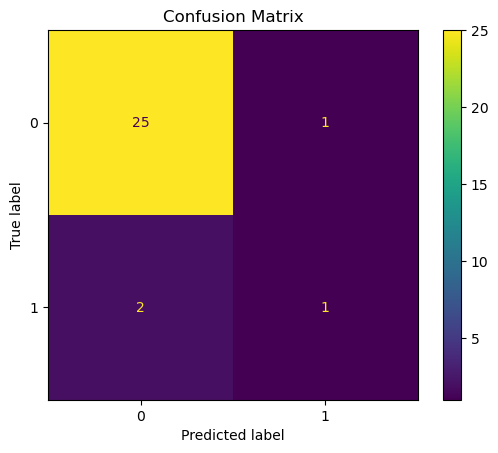

Logistic Regression Metrics:
Accuracy: 0.8966
Precision: 0.5000
Recall: 0.3333
F1 Score: 0.4000
Test Loss: 1.0065, Test Accuracy: 0.8688


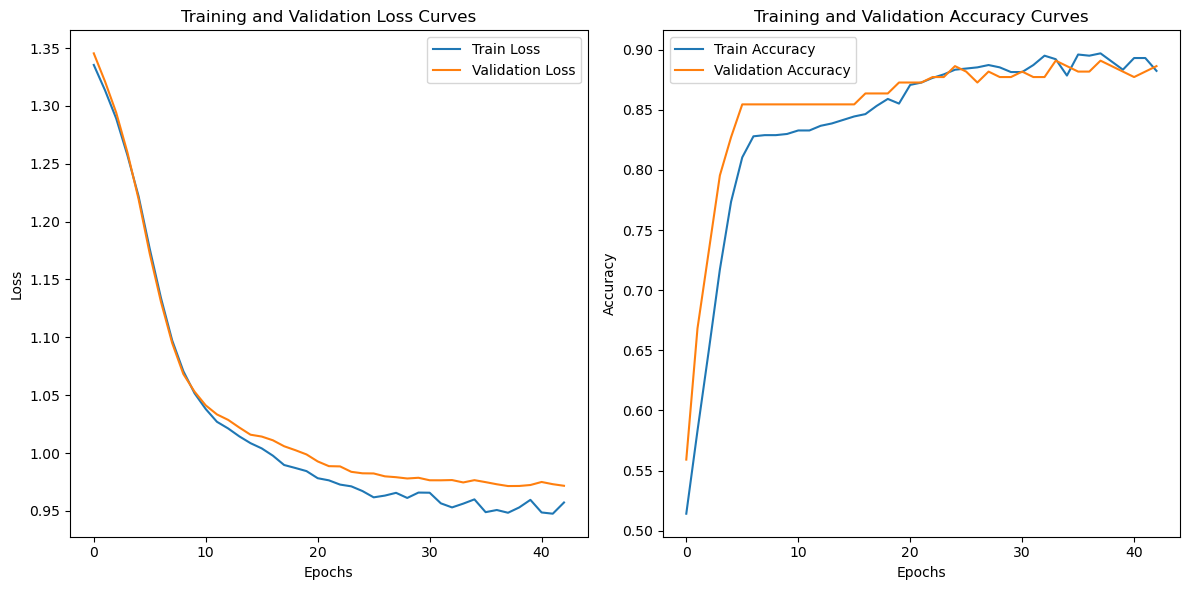

In [68]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='constant', constant_value = 0.1)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_hinge_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

No initialization required
Epoch [1/50], Train Loss: 0.7389, Train Accuracy: 0.4947, Val Loss: 0.6702, Val Accuracy: 0.5682
Epoch [2/50], Train Loss: 0.6614, Train Accuracy: 0.6103, Val Loss: 0.6229, Val Accuracy: 0.7000
Epoch [3/50], Train Loss: 0.6075, Train Accuracy: 0.6706, Val Loss: 0.5824, Val Accuracy: 0.7727
Epoch [4/50], Train Loss: 0.5584, Train Accuracy: 0.7201, Val Loss: 0.5285, Val Accuracy: 0.8227
Epoch [5/50], Train Loss: 0.5132, Train Accuracy: 0.7658, Val Loss: 0.5206, Val Accuracy: 0.8091
Epoch [6/50], Train Loss: 0.5169, Train Accuracy: 0.7629, Val Loss: 0.4580, Val Accuracy: 0.8545
Epoch [7/50], Train Loss: 0.4902, Train Accuracy: 0.7716, Val Loss: 0.4754, Val Accuracy: 0.8227
Epoch [8/50], Train Loss: 0.4614, Train Accuracy: 0.7930, Val Loss: 0.4347, Val Accuracy: 0.8318
Epoch [9/50], Train Loss: 0.4467, Train Accuracy: 0.8115, Val Loss: 0.4150, Val Accuracy: 0.8500
Epoch [10/50], Train Loss: 0.4218, Train Accuracy: 0.8202, Val Loss: 0.4086, Val Accuracy: 0.8545
Ep

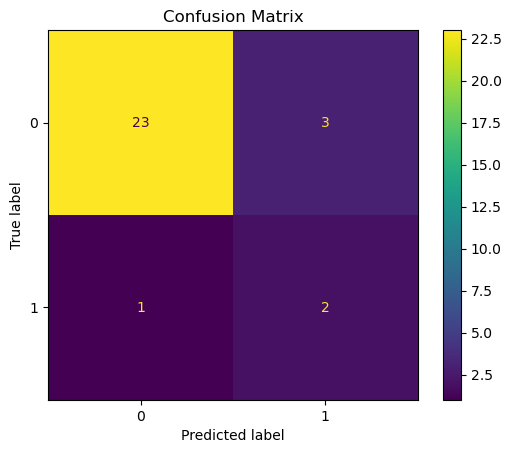

Logistic Regression Metrics:
Accuracy: 0.8621
Precision: 0.4000
Recall: 0.6667
F1 Score: 0.5000
Test Loss: 0.3206, Test Accuracy: 0.8552


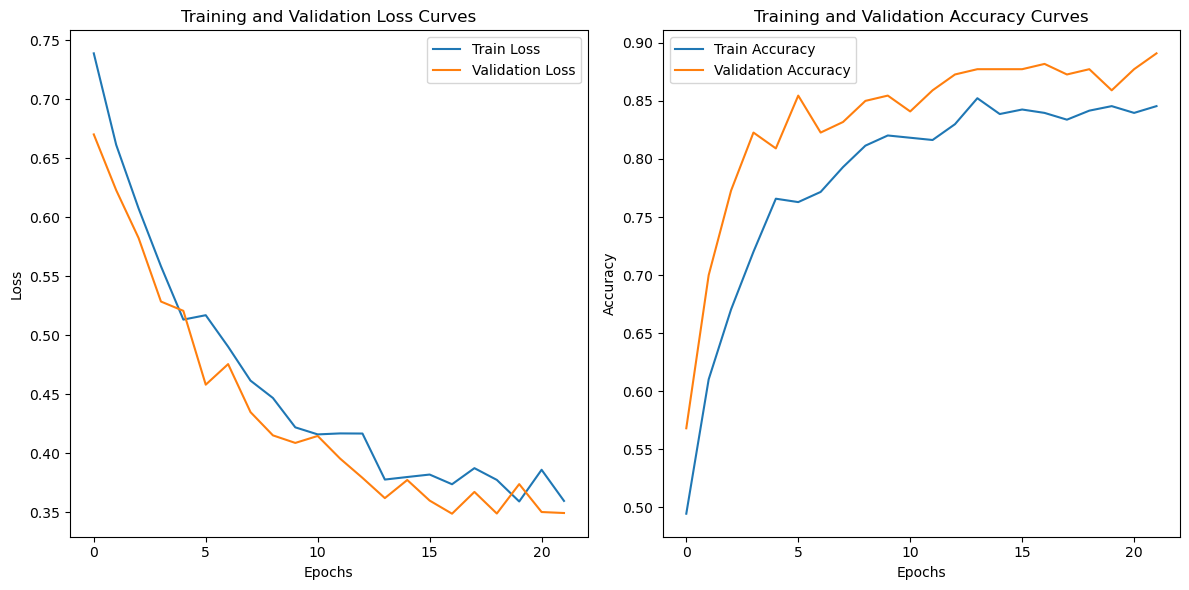

In [69]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='none', constant_value = 0.1)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

## M. KL Divergance

### M.1 - Model Initialization, Loss Function and Optimizer utilizing KL Divergance Loss Function

Epoch [1/50], Train Loss: 0.6874, Train Accuracy: 0.8105, Val Loss: 0.6785, Val Accuracy: 0.8545
Epoch [2/50], Train Loss: 0.6607, Train Accuracy: 0.8581, Val Loss: 0.6486, Val Accuracy: 0.8545
Epoch [3/50], Train Loss: 0.6135, Train Accuracy: 0.8610, Val Loss: 0.6004, Val Accuracy: 0.8545
Epoch [4/50], Train Loss: 0.5474, Train Accuracy: 0.8805, Val Loss: 0.5325, Val Accuracy: 0.8545
Epoch [5/50], Train Loss: 0.4801, Train Accuracy: 0.8678, Val Loss: 0.4480, Val Accuracy: 0.8909
Epoch [6/50], Train Loss: 0.4220, Train Accuracy: 0.8669, Val Loss: 0.4052, Val Accuracy: 0.9000
Epoch [7/50], Train Loss: 0.3856, Train Accuracy: 0.8678, Val Loss: 0.3678, Val Accuracy: 0.8955
Epoch [8/50], Train Loss: 0.3637, Train Accuracy: 0.8717, Val Loss: 0.3562, Val Accuracy: 0.8955
Epoch [9/50], Train Loss: 0.3522, Train Accuracy: 0.8630, Val Loss: 0.3372, Val Accuracy: 0.8864
Epoch [10/50], Train Loss: 0.3339, Train Accuracy: 0.8785, Val Loss: 0.3391, Val Accuracy: 0.8636
Epoch [11/50], Train Loss: 0.

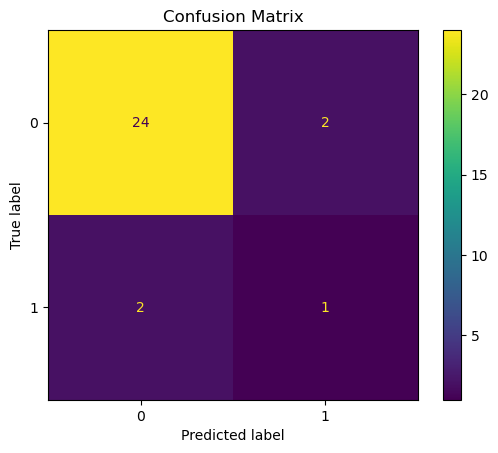

Logistic Regression Metrics:
Accuracy: 0.8621
Precision: 0.3333
Recall: 0.3333
F1 Score: 0.3333
Test Loss: 0.3133, Test Accuracy: 0.8643


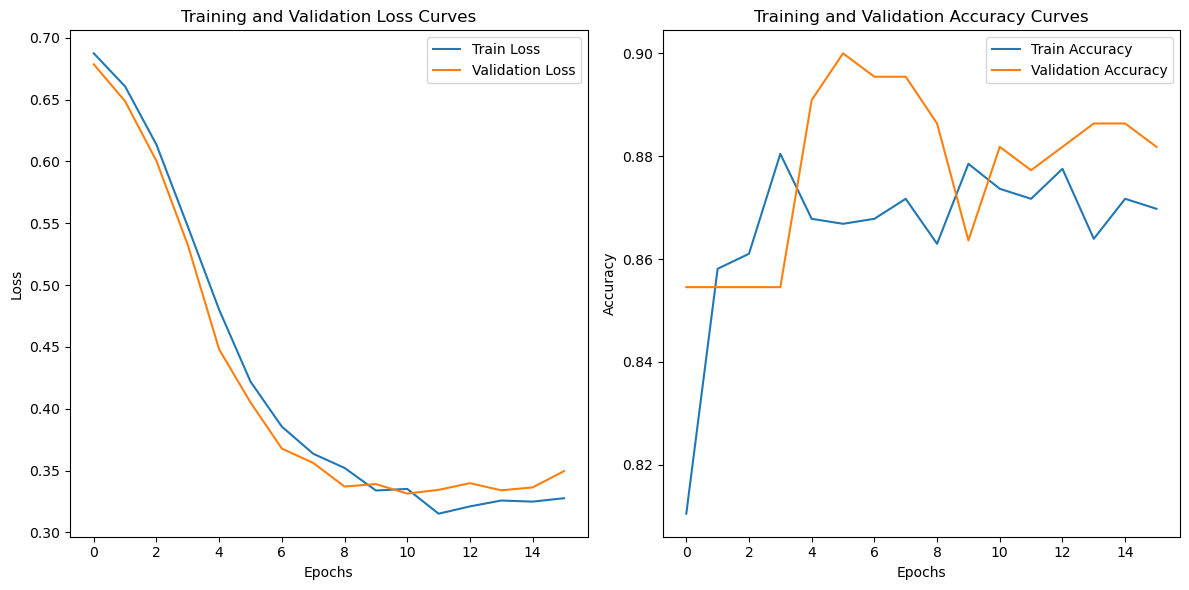

In [70]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='normal', mean=0.0, std=0.01)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_kl_divergence
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

Epoch [1/50], Train Loss: 0.7472, Train Accuracy: 0.5121, Val Loss: 0.6875, Val Accuracy: 0.5727
Epoch [2/50], Train Loss: 0.6896, Train Accuracy: 0.5831, Val Loss: 0.6544, Val Accuracy: 0.6864
Epoch [3/50], Train Loss: 0.6502, Train Accuracy: 0.6676, Val Loss: 0.6252, Val Accuracy: 0.7318
Epoch [4/50], Train Loss: 0.6185, Train Accuracy: 0.7405, Val Loss: 0.5919, Val Accuracy: 0.7955
Epoch [5/50], Train Loss: 0.5823, Train Accuracy: 0.7852, Val Loss: 0.5513, Val Accuracy: 0.8273
Epoch [6/50], Train Loss: 0.5444, Train Accuracy: 0.8134, Val Loss: 0.5087, Val Accuracy: 0.8545
Epoch [7/50], Train Loss: 0.5074, Train Accuracy: 0.8280, Val Loss: 0.4724, Val Accuracy: 0.8545
Epoch [8/50], Train Loss: 0.4729, Train Accuracy: 0.8299, Val Loss: 0.4440, Val Accuracy: 0.8545
Epoch [9/50], Train Loss: 0.4451, Train Accuracy: 0.8290, Val Loss: 0.4237, Val Accuracy: 0.8545
Epoch [10/50], Train Loss: 0.4288, Train Accuracy: 0.8299, Val Loss: 0.4073, Val Accuracy: 0.8545
Epoch [11/50], Train Loss: 0.

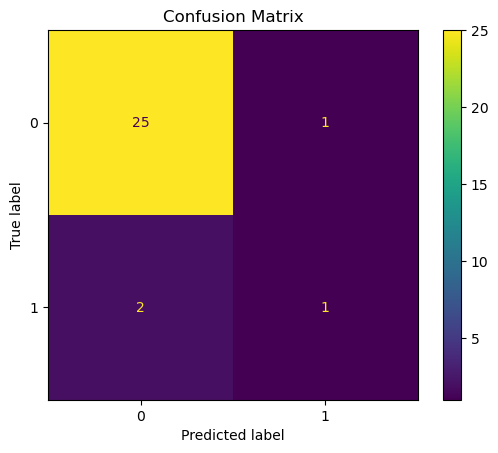

Logistic Regression Metrics:
Accuracy: 0.8966
Precision: 0.5000
Recall: 0.3333
F1 Score: 0.4000
Test Loss: 0.2891, Test Accuracy: 0.8824


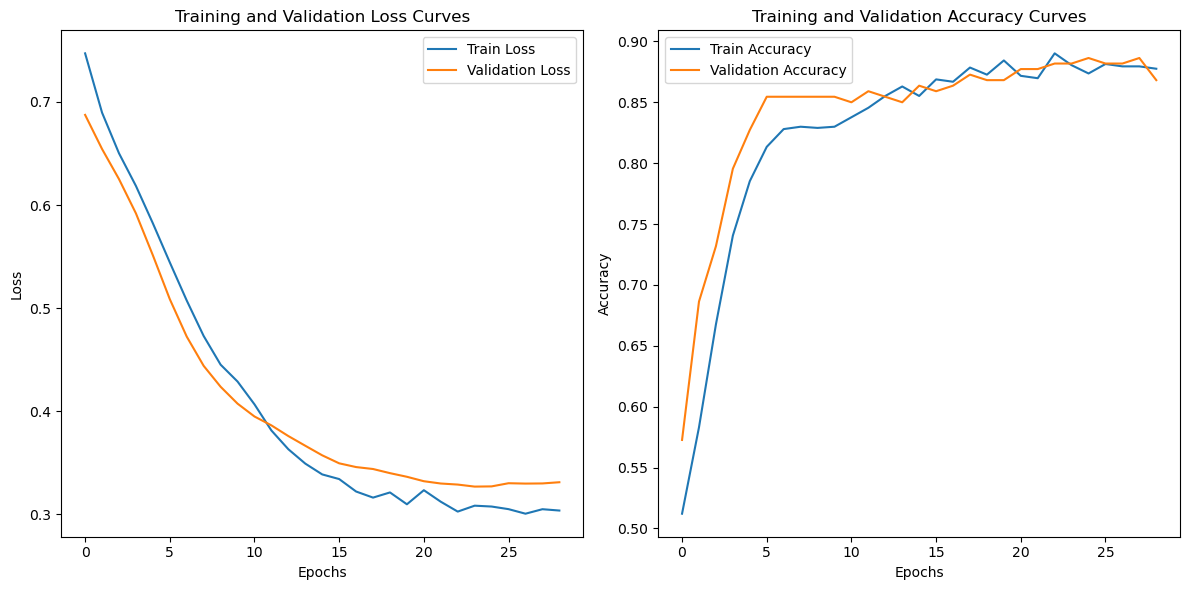

In [71]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='constant', constant_value = 0.1)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_kl_divergence
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

No initialization required
Epoch [1/50], Train Loss: 0.6795, Train Accuracy: 0.5879, Val Loss: 0.6075, Val Accuracy: 0.7682
Epoch [2/50], Train Loss: 0.5862, Train Accuracy: 0.6880, Val Loss: 0.5800, Val Accuracy: 0.7591
Epoch [3/50], Train Loss: 0.5627, Train Accuracy: 0.7162, Val Loss: 0.5571, Val Accuracy: 0.7591
Epoch [4/50], Train Loss: 0.5246, Train Accuracy: 0.7609, Val Loss: 0.5028, Val Accuracy: 0.8182
Epoch [5/50], Train Loss: 0.4872, Train Accuracy: 0.7843, Val Loss: 0.4470, Val Accuracy: 0.8636
Epoch [6/50], Train Loss: 0.4661, Train Accuracy: 0.7862, Val Loss: 0.4505, Val Accuracy: 0.8455
Epoch [7/50], Train Loss: 0.4460, Train Accuracy: 0.8066, Val Loss: 0.4194, Val Accuracy: 0.8682
Epoch [8/50], Train Loss: 0.4429, Train Accuracy: 0.8241, Val Loss: 0.4151, Val Accuracy: 0.8591
Epoch [9/50], Train Loss: 0.4168, Train Accuracy: 0.8231, Val Loss: 0.3913, Val Accuracy: 0.8682
Epoch [10/50], Train Loss: 0.4058, Train Accuracy: 0.8309, Val Loss: 0.3793, Val Accuracy: 0.8727
Ep

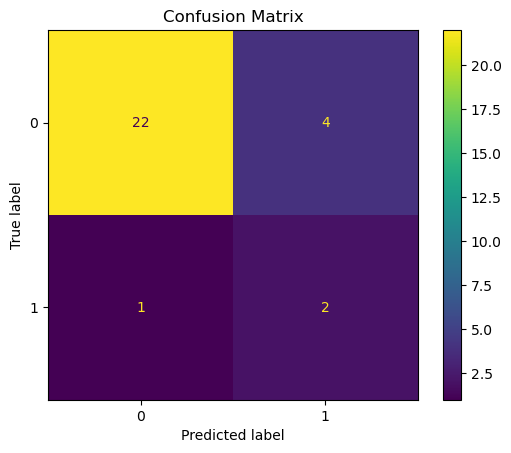

Logistic Regression Metrics:
Accuracy: 0.8276
Precision: 0.3333
Recall: 0.6667
F1 Score: 0.4444
Test Loss: 0.3070, Test Accuracy: 0.8462


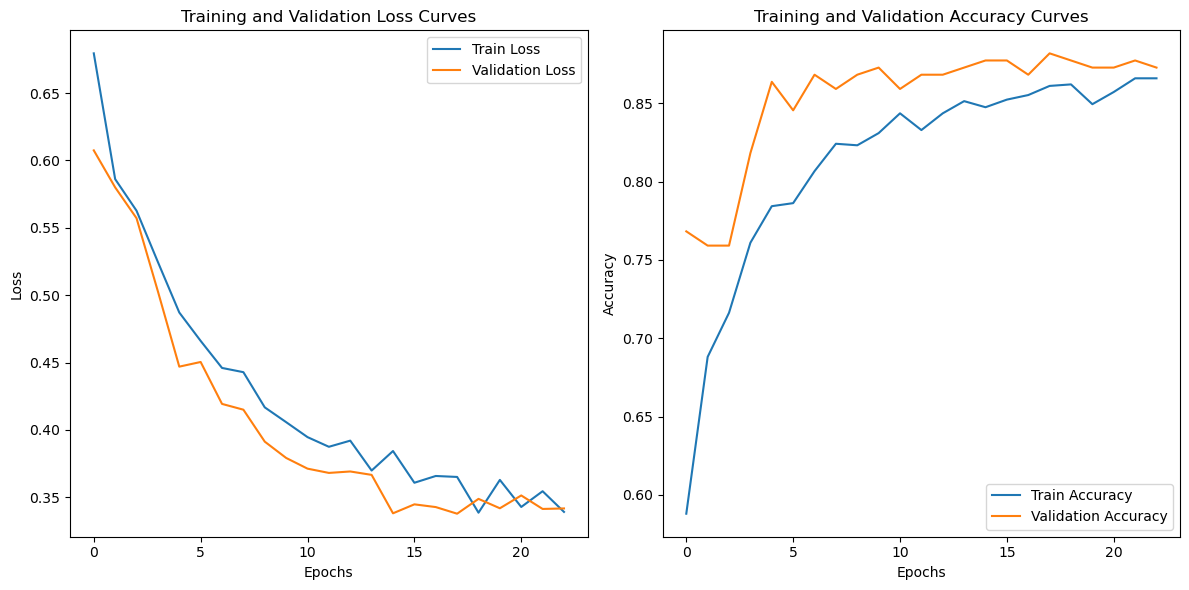

In [72]:
model = MLP().to(device)

# Apply weight initialization (optional)
initialize_weights(model, method='none', constant_value = 0.1)  # Example: Normal initialization
# initialize_weights(model)  # Uncomment to skip initialization

# Initialize loss function and optimizer
criterion = custom_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()